In [30]:
import numpy as np
import math
import scipy
np.random.seed(42) #set seed

def calcDist(r1, r2):  #helper function
    tmp = r1-r2
    tmp = tmp ** 2
    return(math.sqrt(np.sum(tmp)))

def calcCCD(ref, cormat):  #standard CCD from Hughey
    upper_ref = np.triu(ref)
    upper_corrmat = np.triu(cormat)
    ccd = calcDist(upper_corrmat, upper_ref)
    return(ccd)

def calcCCS(ref, cormat):  #distance to null matrix - distance to ref
    upper_ref = np.triu(ref)
    upper_corrmat = np.triu(cormat)
    null = np.identity(ref.shape[0])
    ccd = calcDist(upper_corrmat, upper_ref)
    # print("ccd: ", ccd)
    ncd = calcDist(upper_corrmat, null)
    # print("ncd: ", ncd)
    # denom = np.triu(ref)**2
    # denom = math.sqrt(np.sum(denom - np.identity(ref.shape[0])))
    # print("denom: " + str(denom))
    # print("result score: {}".format((ncd-ccd)))
    return((ncd-ccd))

def calcCCS2(ref, cormat): #distance to -ref minus distance to ref
    upper_ref = np.triu(ref)
    upper_corrmat = np.triu(cormat)
    neg_ref = -1*upper_ref
    np.fill_diagonal(neg_ref, 1.)

    # print(neg_ref)
    ccd = calcDist(upper_corrmat, upper_ref)
    ccd2 = calcDist(upper_corrmat, neg_ref)
    
    return((ccd2-ccd))


Little test:

In [31]:
ref = np.array([[1, 2, 3],
                [2, 1, -1],
                [3, -1, 1]])
cor  = np.array([[1, 1, 1],
                 [0, 1, 1],
                 [0, 0, 1]])
print("method1: {}".format(calcCCS(ref, cor)))
print("method2: {}".format(calcCCS2(ref, cor)))
print((calcCCS(ref, cor)) - (calcCCS2(ref, cor)))

method1: -0.3388736758509975
method2: 2.0
-2.3388736758509974


Define a Reference Matrix:

In [32]:
ref = np.array([[1, 0.7754709, 0.72492855, 0.27817942, 0.3, 0.38, -0.8614806, -0.7471112, -0.59455286, -0.8234182, -0.9146447, -0.847398],
                    [0.7754709, 1, 0.63439613, 0.07402797, 0.07, 0.1, -0.7461844, -0.645078, -0.70865725, -0.784541, -0.7654845, -0.7983427],
                    [0.7249286, 0.63439613, 1, 0.06541974, 0.05, 0.02, -0.6031795, -0.6364953, -0.56958405, -0.7144612, -0.6455111, -0.7595101],
                    [0.2781794, 0.07402797, 0.06541974, 1, 0.8, 0.77, -0.4099044, -0.1411756, 0.25538496, -0.0252816, -0.3401805, -0.0781101],
                    [0.3, 0.07, 0.05, 0.8, 1, 0.66, -0.5, -0.1, 0.05, 0.1, -0.3, 0.01],
                    [0.38, 0.1, 0.02, 0.77, 0.66, 1, -0.3, 0.01, -0.04, 0.2, -0.2, -0.1],
                    [-0.8614806, -0.74618443, -0.60317949, -0.40990436, -0.5, -0.3, 1, 0.7132144, 0.52923596, 0.7673822, 0.9111478, 0.7487607],
                    [-0.7471112, -0.64507795, -0.6364953, -0.14117556, -0.1, 0.01, 0.7132144, 1, 0.6079441, 0.7467579, 0.7732704, 0.7756198],
                    [-0.5945529, -0.70865725, -0.56958405, 0.25538496, 0.05, -0.04, 0.529236, 0.6079441, 1, 0.7868302, 0.5543211, 0.7530874],
                    [-0.8234182, -0.78454102, -0.71446119, -0.0252816, 0.1, 0.2, 0.7673822, 0.7467579, 0.78683019, 1, 0.8117621, 0.8738338],
                    [-0.9146447, -0.76548454, -0.64551113, -0.34018047, -0.3, -0.2, 0.9111478, 0.7732704, 0.55432112, 0.8117621, 1, 0.8443479],
                    [-0.847398, -0.79834269, -0.75951011, -0.0781101, 0.01, -0.1, 0.7487607, 0.7756198, 0.7530874, 0.8738338, 0.8443479, 1]])

Run both CCS scoring schemes on a bunch of different matrices:

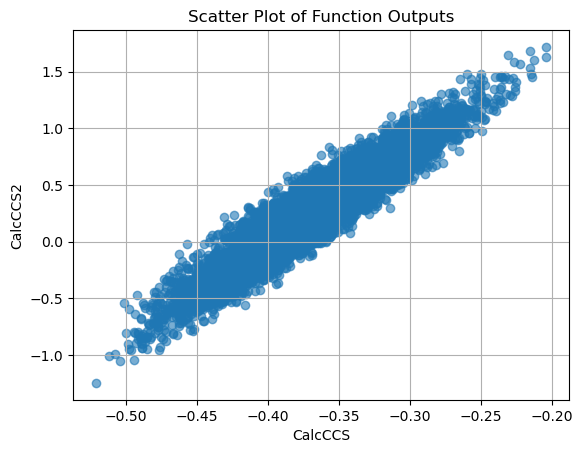

Correlation Coefficient: 0.9441373286164392


In [33]:
import matplotlib.pyplot as plt

num_matrices = 10000
matrix_size = (12, 12)  # Define the size of the matrices
matrices = [np.random.rand(*matrix_size) for _ in range(num_matrices)]
symmetric = [A.T * A for A in matrices]

# plt.imshow( symmetric[0], cmap = "RdBu" )


# Compute the scalars for each matrix using the two functions
scalars1 = [calcCCS(ref, matrix) for matrix in matrices]
scalars2 = [calcCCS2(ref, matrix) for matrix in matrices]

# Plot the resulting scalars as a scatter plot
plt.scatter(scalars1, scalars2, alpha=0.6)
plt.xlabel('CalcCCS')
plt.ylabel('CalcCCS2')
plt.title('Scatter Plot of Function Outputs')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(scalars1, scalars2)[0, 1]
print(f'Correlation Coefficient: {correlation_coefficient}')


Do the CCS and CCD scores go down as you add noise to reference matrix?

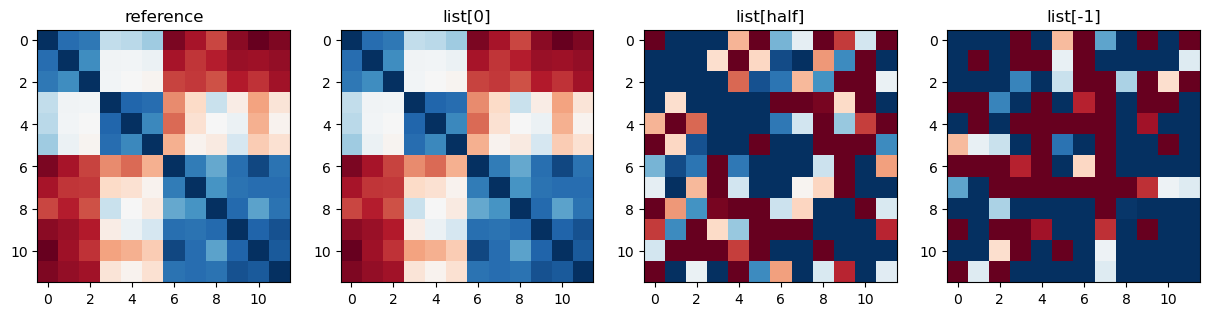

In [34]:
import numpy as np
from matplotlib.colors import Normalize

def generate_noisy_matrices(S, num_matrices, noise_level):
    # Ensure the matrix is symmetric
    if not np.allclose(S, S.T):
        raise ValueError("The matrix is not symmetric")
    
    # Get the size of the matrix
    n = S.shape[0]
    
    # Initialize the list to hold the noisy matrices
    noisy_matrices = []
    
    for i in range(num_matrices):
        # Generate a random noise matrix
        noise = np.random.randn(n, n)
        # Make it symmetric
        noise = (noise + noise.T) / 2
        # Scale the noise
        scaled_noise = noise * (i / (num_matrices - 1)) * noise_level
        # Add the noise to the original matrix
        noisy_matrix = S + scaled_noise
        noisy_matrix = np.clip(noisy_matrix, -1, 1)
        noisy_matrices.append(noisy_matrix)
    
    return noisy_matrices

# Example usage
num_matrices = 101  # Total number of matrices
noise_level = 4  # Noise level

noisy_matrices = generate_noisy_matrices(ref, num_matrices, noise_level)

fig, axes = plt.subplots(1, 4, figsize=(15, 6))
axes[0].set_title('reference')
im = axes[0].imshow(ref, cmap = "RdBu")
axes[1].set_title('list[0]')
im = axes[1].imshow(noisy_matrices[0], cmap = "RdBu" )
axes[2].set_title('list[half]')
im = axes[2].imshow(noisy_matrices[math.floor(num_matrices/2)], cmap = "RdBu")
axes[3].set_title('list[-1]')
im = axes[3].imshow(noisy_matrices[-1], cmap = "RdBu",  norm=Normalize(vmin=-1, vmax=1))


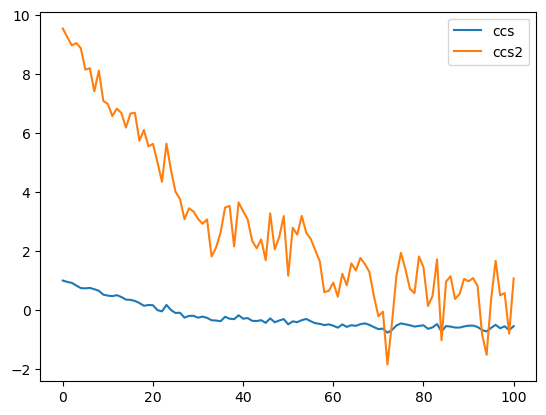

In [35]:
resultCCS = [calcCCS(i, ref) for i in noisy_matrices]
plt.plot(resultCCS)
resultCCS2 = [calcCCS2(i, ref) for i in noisy_matrices]
plt.plot(resultCCS2)
plt.legend(["ccs", "ccs2"])